In [3]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [4]:
## parameters cell
itp_id = 300

In [5]:
airtable_organizations = (
    tbl.airtable.california_transit_organizations()
    >> select(_.itp_id, _.name, _.caltrans_district,
              _.website, _.ntp_id, _.drmt_organization_name)
    >> filter(_.itp_id == itp_id)
    >> collect()
)

In [6]:
# airtable_organizations

In [7]:
if itp_id in [61, 301]:
    analysis_date = dt.date(2022, 6, 8) ##wednesday, new tables for Napa operators
elif itp_id == 273:
    analysis_date = dt.date(2022, 2, 8) ## override for SacRT
elif itp_id == 208:
    analysis_date = dt.date(2022, 7, 20) ## override for MST
else:
    analysis_date = dt.date(2022, 8, 10) ##wednesday, new tables

In [8]:
%%capture_parameters
human_date = analysis_date.strftime('%B %d (%A)')
human_date

{"human_date": "August 14 (Sunday)"}


In [9]:
%%capture
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

In [10]:
%%capture_parameters
agency_name = rt_day.calitp_agency_name
if itp_id == 61:
    district = '04 - Oakland' ## Airtable error for 61
else:
    district = airtable_organizations.caltrans_district.iloc[0]
agency_name, district

{"agency_name": "Big Blue Bus", "district": "07 - Los Angeles"}


# {agency_name}

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for {agency_name}, with a map each for the morning peak, midday, and afternoon peak periods on {human_date}.
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

In [11]:
## avoid papermill errors when map fails to render
m = None

## Morning Peak

In [12]:
%%capture
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [13]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [14]:
m

In [15]:
rt_day.describe_slow_routes()

AM Peak slowest routes: 
 * 2, Wilshire Blvd/UCLA, Southbound: 0.5 mph median trip speed for 1 trip
 * 14, Bundy Dr & Centinela Ave, Northbound: 1.5 mph median trip speed for 2 trips
 * 17, Culver City Sta - UCLA, Northbound: 3.9 mph median trip speed for 2 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Southbound: 4.1 mph median trip speed for 1 trip
 * 18, UCLA - Marina del Rey, Northbound: 6.3 mph median trip speed for 1 trip
 * 9, Pacific Palisades, Eastbound: 7.7 mph median trip speed for 1 trip
 * 1, Main St & Santa Monica Blvd/UCLA, Southbound: 8.4 mph median trip speed for 7 trips

## Midday

In [16]:
%%capture
rt_day.set_filter(start_time='10:00', end_time='14:00')

In [17]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [18]:
m

In [19]:
rt_day.describe_slow_routes()

Midday slowest routes: 
 * 2, Wilshire Blvd/UCLA, Southbound: 6.6 mph median trip speed for 11 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Northbound: 7.3 mph median trip speed for 17 trips
 * R12, Venice/Westwood Sta/UCLA Rapid, Northbound: 7.8 mph median trip speed for 12 trips
 * 9, Pacific Palisades, Southbound: 8.3 mph median trip speed for 6 trips
 * 9, Pacific Palisades, Eastbound: 8.3 mph median trip speed for 6 trips
 * 8, Ocean Park Blvd & Westwood Bl/UCLA, Southbound: 8.6 mph median trip speed for 8 trips
 * 3, Lincoln Blvd/LAX, Eastbound: 9.0 mph median trip speed for 15 trips

## Afternoon Peak

In [20]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')

In [21]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [22]:
m

In [23]:
rt_day.describe_slow_routes()

PM Peak slowest routes: 
 * 1, Main St & Santa Monica Blvd/UCLA, Northbound: 6.9 mph median trip speed for 12 trips
 * 2, Wilshire Blvd/UCLA, Southbound: 7.1 mph median trip speed for 12 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Southbound: 8.1 mph median trip speed for 15 trips
 * 8, Ocean Park Blvd & Westwood Bl/UCLA, Northbound: 8.4 mph median trip speed for 9 trips
 * R12, Venice/Westwood Sta/UCLA Rapid, Northbound: 8.4 mph median trip speed for 8 trips
 * 17, Culver City Sta - UCLA, Northbound: 8.8 mph median trip speed for 9 trips
 * 7, Pico Blvd, Eastbound: 8.8 mph median trip speed for 15 trips

In [24]:
try:
    metrics_df = (rt_day.rt_trips
         >> group_by(_.route_short_name, _.direction_id)
         >> summarize(speed_variance = _.mean_speed_mph.var(),
                     mean_speed_mph = _.mean_speed_mph.mean(),
                     min_hour = _.median_time.min().hour,
                     max_hour = _.median_time.max().hour,
                     n = _.route_short_name.size)
         >> filter(_.min_hour <= 7, _.max_hour >= 15,
                   _.mean_speed_mph < _.mean_speed_mph.quantile(.6),
                   _.speed_variance, _.n > _.n.quantile(.4))
         >> arrange(-_.speed_variance)
         >> head(20)
        )
except Exception as e:
    pass
    # print(e)
## check that route has all-day span...

In [25]:
def map_from_metrics(rt_day, metrics_df):
    def show_title_and_map():
        try:
            am_map = rt_day.segment_speed_map(how='low_speeds', no_title = True)
            display(Markdown(f'20th Percentile Vehicle Speeds Between Stops{rt_day.filter_formatted}'))
            display(am_map)
        except Exception as e:
            display(Markdown(f'Map not available for this time/route'))
            pass
        return
    try:
        route_name = metrics_df.iloc[1,0]
        direction_id = metrics_df.iloc[1,1]
        # print(route_name, direction_id)
    except Exception as e:
        # print(e)
        return
    rt_day.set_filter(start_time='06:00', end_time='09:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()
    
    rt_day.set_filter(start_time='10:00', end_time='14:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    rt_day.set_filter(start_time='15:00', end_time='19:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    return

## Daily Speed Patterns

* This chart shows the distribution of median trip speeds throughout the day. It can help find times of day where transit riders experience the slowest overall speeds.

Median Trip Speed by Hour of Day, All Routes, 06:00–22:00, Aug 14 (Sun)

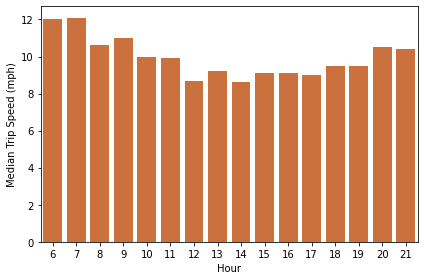

In [26]:
try:
    rt_day.set_filter(start_time='06:00', end_time='22:00')
    display(Markdown(f'Median Trip Speed by Hour of Day{rt_day.filter_formatted}'))

    rt_day.chart_speeds(no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

## Single-Route Detail Example

* These maps highlight a single route which runs throughout the day, with a low average trip speed and a high amount of variation in speeds between different trips.

In [27]:
try:
    map_from_metrics(rt_day, metrics_df)
except Exception as e:
    # print(e)
    pass

20th Percentile Vehicle Speeds Between Stops, Route(s) 8, AM Peak, Aug 14 (Sun)

20th Percentile Vehicle Speeds Between Stops, Route(s) 8, Midday, Aug 14 (Sun)

20th Percentile Vehicle Speeds Between Stops, Route(s) 8, PM Peak, Aug 14 (Sun)

## Single Route Speed Variability

* This chart shows the _variability_ in speeds experienced by afternoon peak trips on the route mapped above. In this chart, each vertical strip corresponds to a segment of the map above. Within each strip, each dot represents the speed experienced in that segment by each trip in the afternoon peak. The segments are labelled by their end stop, generally a cross-street. Segments with high variability (some fast trips and some slow trips) might be better-suited to a different set of projects than segments that experience consistently slow speeds.

Speed Variablity by Stop Segment, Route(s) 8, PM Peak, Aug 14 (Sun)

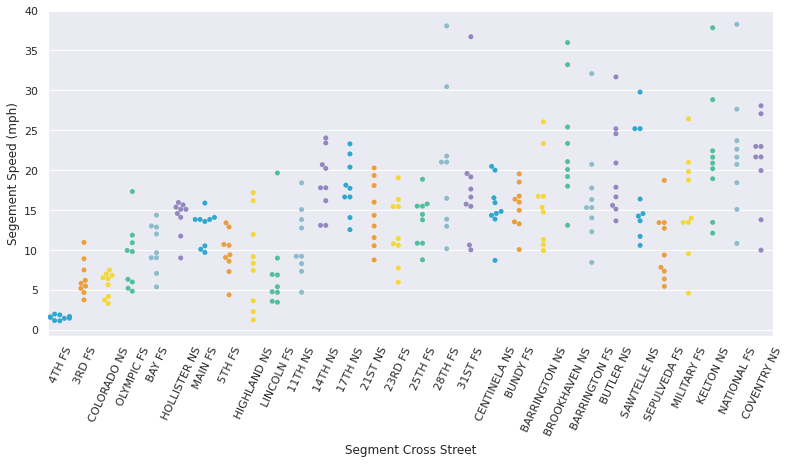

In [28]:
try:
    rt_day.filter['shape_ids'] = [(rt_day._filter(rt_day.rt_trips) >> count(_.shape_id)).shape_id.iloc[0]]

    display(Markdown(f'Speed Variablity by Stop Segment{rt_day.filter_formatted}'))

    ## filter to a max number of segments to display, split out title
    rt_day.chart_variability(num_segments=30, no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass